### Setup for Google Colab

If you are running this notebook in Google Colab, complete the following steps:

1. In Colab, we recommend going to **Runtime → Change runtime type** and selecting **T4 GPU**
2. Install **TerraTorch** and the required packages
3. Download the dataset (as part of the notebook)

In [ ]:
!pip install terratorch==1.2
!pip install gdown tensorboard

------------

## AGB Data Tutorial (Prithvi)

### Download the dataset

In [26]:
import os
import gdown
import zipfile
from pathlib import Path

if not os.path.isfile('granite-geospatial-biomass-dataset.zip'):
    gdown.download("https://drive.google.com/uc?id=1s0i_gGL8_zWha3V3yV2MGCPg20YL2y96")
    
if not os.path.isdir('granite-geospatial-biomass-dataset/'):
    with zipfile.ZipFile('granite-geospatial-biomass-dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('granite-geospatial-biomass-dataset')

In [27]:
dataset_path = Path('granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset')
!ls "granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset"

test_images  test_labels  train_images train_labels val_images   val_labels


### Build datamodule

In [9]:
from terratorch.datamodules import GenericNonGeoPixelwiseRegressionDataModule
import albumentations as A

datamodule = GenericNonGeoPixelwiseRegressionDataModule(
    batch_size=4,
    num_workers=2,
    num_classes=2,
    check_stackability = False,
    
    # Define dataset paths 
    train_data_root=dataset_path / 'train_images/',
    train_label_data_root=dataset_path / 'train_labels/',
    val_data_root=dataset_path / 'val_images/',
    val_label_data_root=dataset_path / 'val_labels/',
    test_data_root=dataset_path / 'test_images/',
    test_label_data_root=dataset_path / 'test_labels/',
    
    img_grep='*.tif',
    label_grep='*.tif',
    
    train_transform=[
        A.D4(), # Random flips and rotation
        A.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
        
    # Define standardization values
    means=[
      547.36707,
      898.5121,
      1020.9082,
      2665.5352,
      2340.584,
      1610.1407,
    ],
    stds=[
      411.4701,
      558.54065,
      815.94025,
      812.4403,
      1113.7145,
      1067.641,
    ],
    dataset_bands = [-1, "BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2", -1, -1, -1, -1],
    output_bands = ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
    rgb_indices = [2, 1, 0],
    no_data_replace=0,
    no_label_replace=-1,
)

# Setup train and val datasets
datamodule.setup("fit")

In [30]:
train_dataset = datamodule.train_dataset
val_dataset = datamodule.val_dataset

print(f"Available samples in the training dataset: {len(train_dataset)}")
print(f"Available samples in the validation dataset: {len(val_dataset)}")
print(f"Input shape of first sample: {val_dataset[0]['image'].shape}")

Available samples in the training dataset: 1622
Available samples in the validation dataset: 406
Input shape of first sample: torch.Size([6, 224, 224])


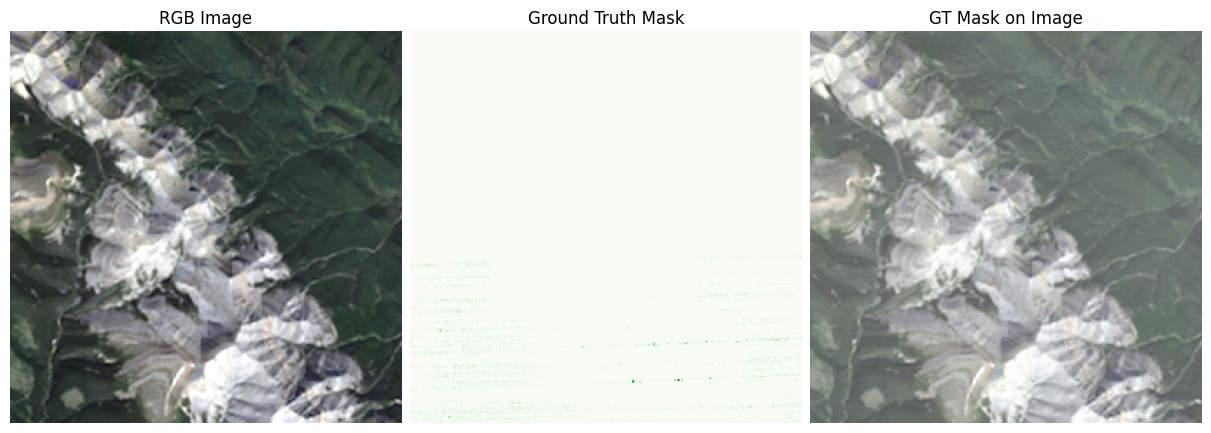

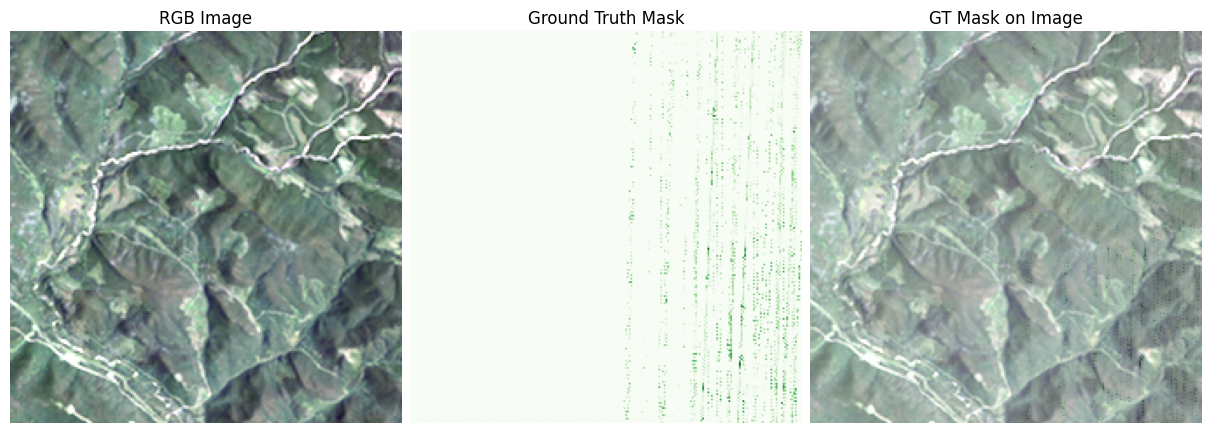

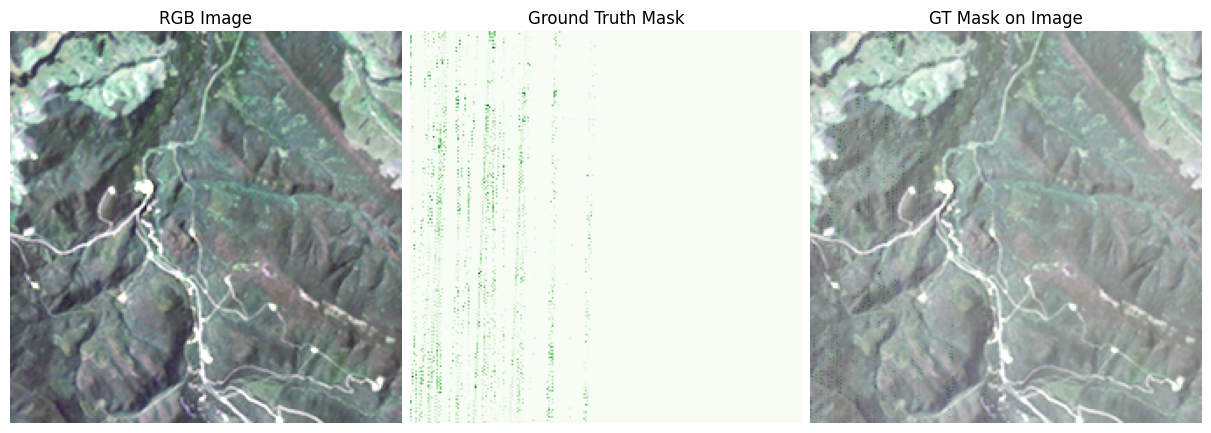

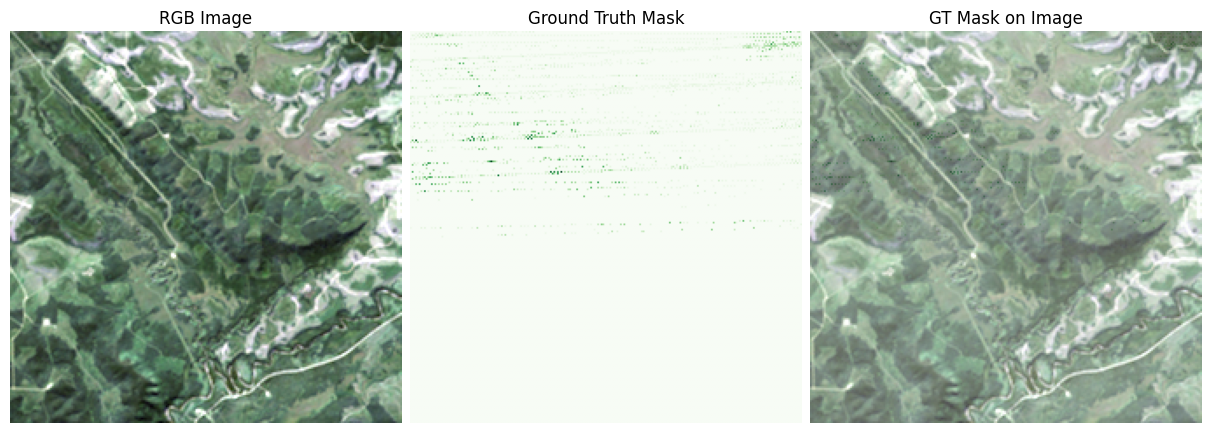

In [31]:
for i in range(4):
    _ = val_dataset.plot(train_dataset[i])

In [32]:
# checking datasets testing split size
datamodule.setup("test")
train_dataset = datamodule.train_dataset

print(f"Available samples in the test dataset: {len(test_dataset)}")

Available samples in the test dataset: 360


### Build training pipeline to finetune Prithvi

In [33]:
from terratorch.tasks import PixelwiseRegressionTask
import lightning.pytorch as pl

pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/agb/checkpoints/",
    monitor="val/RMSE",          # metric to monitor
    mode="min",
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1,                  # single device for notebook stability
    precision="16-mixed",        # speed up training
    num_nodes=1,
    logger=True,                # uses TensorBoard by default
    max_epochs=1,               # demo only
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/agb",
    detect_anomaly=True,
)

# Model
model = PixelwiseRegressionTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300",  # prithvi_eo_v1_100 / prithvi_eo_v2_300 / *_tl / *_600
        "backbone_pretrained": True,
        "backbone_num_frames": 1,
        # "backbone_img_size": 224,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        # "backbone_coords_encoding": ["time", "location"],

        # Necks
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11],   # prithvi_eo_v1_100
                "indices": [5, 11, 17, 23],  # prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31], # prithvi_eo_v2_600
            },
            {"name": "ReshapeTokensToImage"},
            {"name": "LearnedInterpolateToPyramidal"},
        ],

        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        # "head_dropout": 0.16194593880230534,
        # "head_final_act": torch.nn.ReLU,
        # "head_learned_upscale_layers": 2,
    },
    loss="rmse",
    optimizer="AdamW",
    lr=1e-3,
    ignore_index=-1,
    freeze_backbone=True,        # speed up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
)

Seed set to 0
Using 16bit Automatic Mixed Precision (AMP)
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [16]:
# Training
trainer.fit(model, datamodule=datamodule)

/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/terratorch/examples/datasets_and_benchmarks/output/agb/checkpoints exists and is not empty.
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │  324 M │ train │     0 │
│ 1 │ criterion     │ RootLossWrapper  │      0 │ train │     0 │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │     0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │     0 │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │     0 │
└───┴───────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 20.3 M                                                                                           
Non-trainable params: 303 M                                                                                        
Total params: 324 M                                                                                                
Total estimated model params size (MB): 1.3 K                                                                      
Modules in train mode: 643                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/lightning/pytorch/t
rainer/connectors/data_connector.py:429: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up
the dataloader worker initialization.

W0108 22:24:37.101000 34472 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
W0108 22:24:37.101000 34473 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warni

/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/lightning/pytorch/t
rainer/connectors/data_connector.py:429: Consider setting `persistent_workers=True` in 'train_dataloader' to speed 
up the dataloader worker initialization.

W0108 22:24:45.089000 34505 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
W0108 22:24:50.504000 34562 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserW

SystemExit: 1

/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
### Evaluate model and inference

In [17]:
best_ckpt_path = "output/agb/checkpoints/best-epoch=00.ckpt"

In [86]:
import torch 

# Normalization statistics
means = [547.36707, 898.5121, 1020.9082, 2665.5352, 2340.584, 1610.1407]
stds  = [411.4701, 558.54065, 815.94025, 812.4403, 1113.7145, 1067.641]

def run_test_and_visual_inspection(model, ckpt_path):
    # Run the model on the test set
    trainer.test(model, datamodule=datamodule, ckpt_path=ckpt_path)

    # Load the checkpoint for predictions and plotting
    model = model = PixelwiseRegressionTask.load_from_checkpoint(
        ckpt_path,
        model_factory=model.hparams.model_factory,
        model_args=model.hparams.model_args,
    ).to(model.device)

    val_dataloader = datamodule.val_dataloader()
    val_dataset = datamodule.val_dataset

    with torch.no_grad():
        batch = next(iter(val_dataloader))
        images = batch["image"].to(model.device)
        
        # Apply the same normalization used during training
        mean = torch.tensor(means, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
        std = torch.tensor(stds, device=images.device, dtype=images.dtype).view(1, -1, 1, 1)
        images_norm = (images - mean) / std

        outputs = model(images_norm)
        preds = outputs.output

    for i in range(4):
        sample = {key: batch[key][i] for key in batch}
        sample["prediction"] = preds[i]
        sample["image"] = sample["image"].cpu()
        sample["mask"] = sample["mask"].cpu()
        val_dataset.plot(sample)

Restoring states from the checkpoint path at output/agb/checkpoints/best-epoch=00.ckpt
Loaded model weights from the checkpoint at output/agb/checkpoints/best-epoch=00.ckpt
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

W0108 23:26:24.541000 55263 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
W0108 23:26:24.630000 55264 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserW

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    18.325319290161133     │
│         test/MSE          │     1141.952392578125     │
│       test/R2_Score       │    0.40605491399765015    │
│         test/RMSE         │     33.79278564453125     │
│         test/loss         │    31.986326217651367     │
└───────────────────────────┴───────────────────────────┘

W0108 23:26:55.345000 55437 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
W0108 23:26:55.467000 55438 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserW

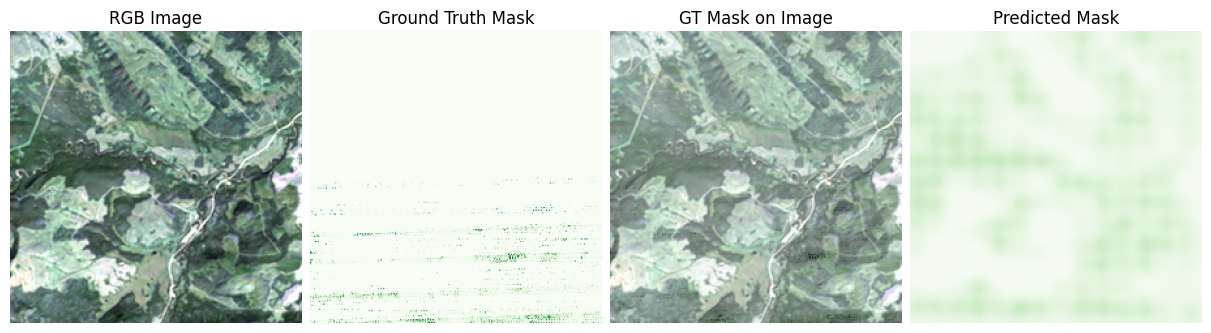

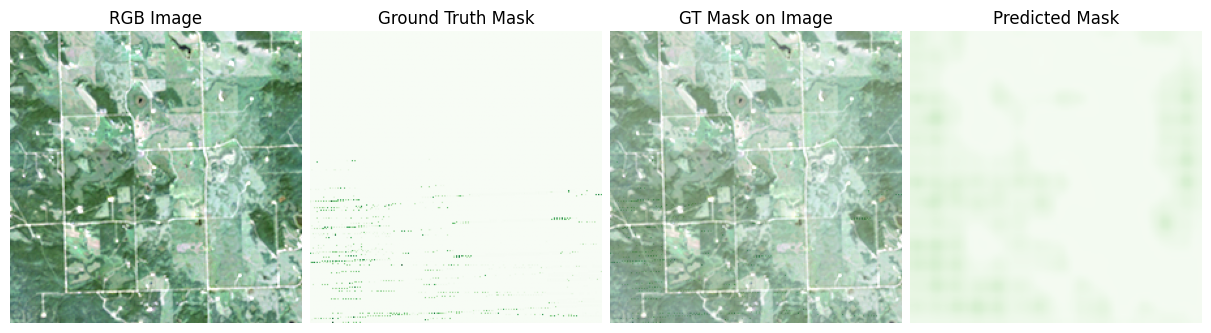

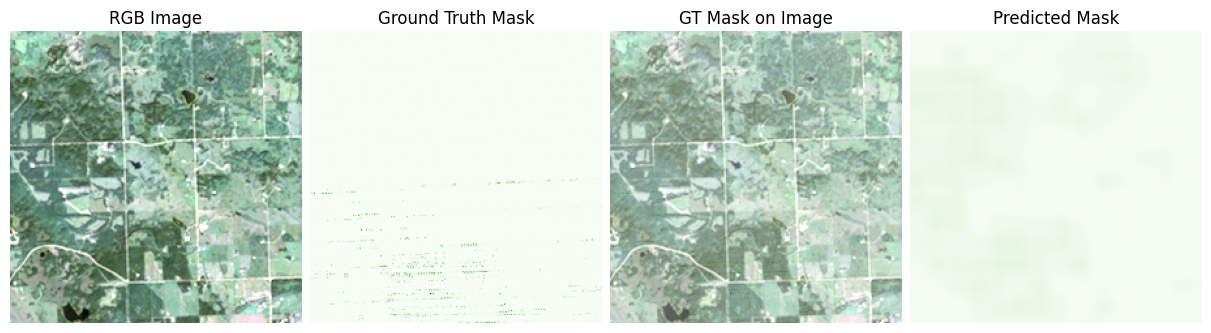

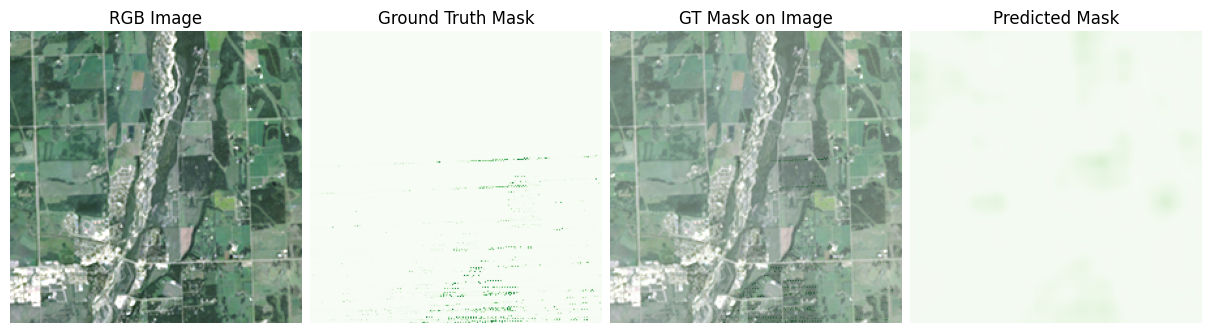

In [87]:
run_test_and_visual_inspection(model, best_ckpt_path)

In [88]:
best_ckpt_100_epoch_path = "agb_best-epoch=68.ckpt"

if not os.path.isfile(best_ckpt_100_epoch_path):
    gdown.download("https://drive.google.com/uc?id=1ACjb4oWb2p_ZA87TQcuSWvCcB4_61fA-")


Restoring states from the checkpoint path at agb_best-epoch=68.ckpt
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:566: The dirpath has changed from '/opt/app-root/src/TerraTorch-Examples/output/agb/checkpoints' to '/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/terratorch/examples/datasets_and_benchmarks/output/agb/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
Loaded model weights from the checkpoint at agb_best-epoch=68.ckpt
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:429: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

W0108 23:27:08.410000 55516 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
W0108 23:27:08.484000 55517 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserW

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    15.740586280822754     │
│         test/MSE          │     1002.483642578125     │
│       test/R2_Score       │    0.48360157012939453    │
│         test/RMSE         │     31.66202163696289     │
│         test/loss         │    29.885894775390625     │
└───────────────────────────┴───────────────────────────┘

W0108 23:27:38.482000 55648 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
W0108 23:27:38.569000 55649 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserW

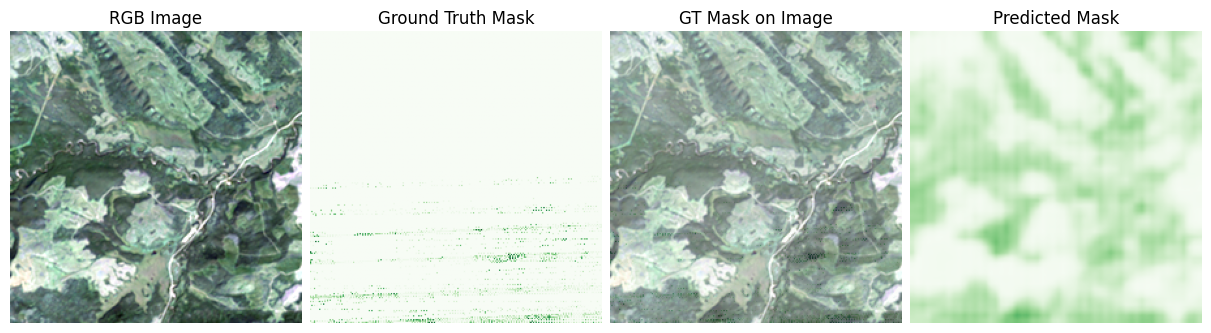

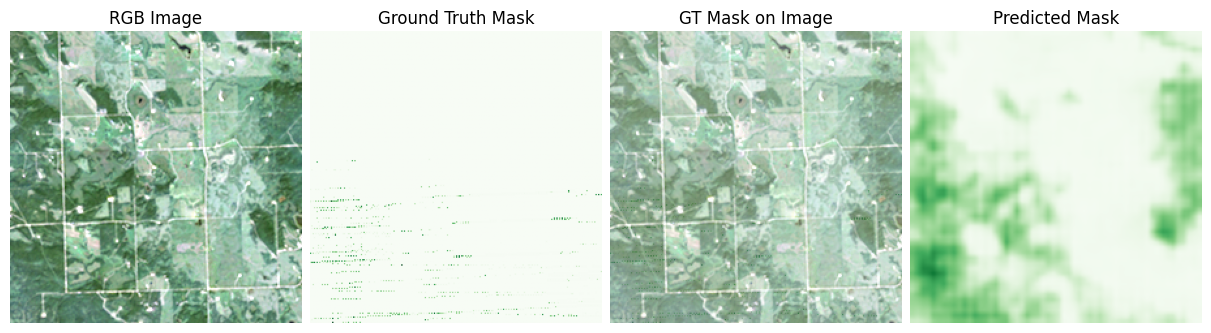

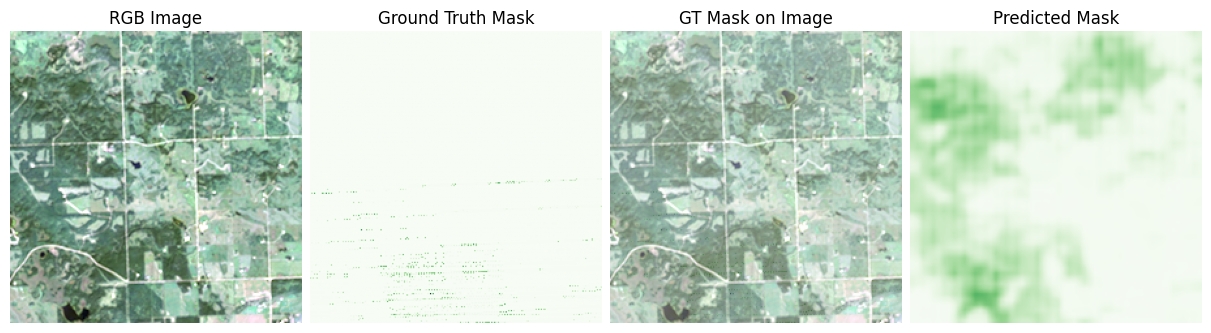

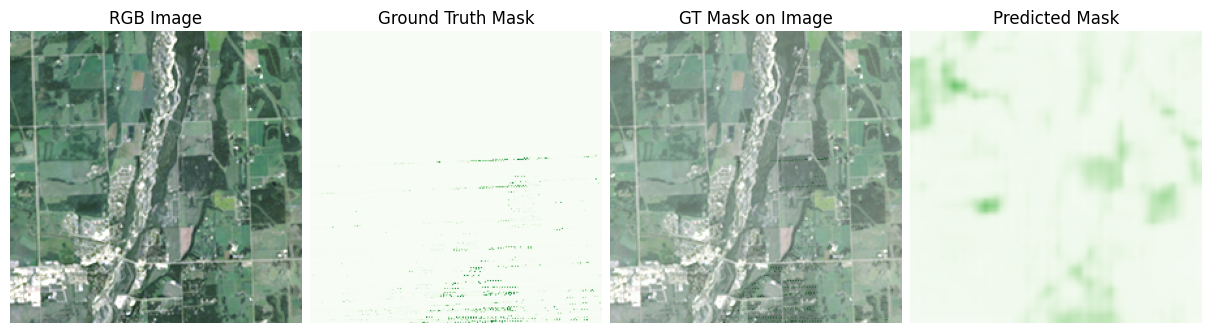

In [89]:
run_test_and_visual_inspection(model, best_ckpt_100_epoch_path)

# Fine-tuning via CLI

You might want to restart the session to free up GPU memory.

In [92]:
# Run fine-tuning
!terratorch fit -c prithvi_v2_eo_300_tl_unet_agb.yaml

W0108 23:29:31.931000 56347 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Seed set to 42
/Users/isw/Documents/1_Embed2Scale/Embedding_Benchmarking/back_env/lib/python3.12/site-packages/lightning/pytorch/cli.py:734: `PixelwiseRegressionTask.configure_optimizers` will be overridden by `MyLightningCLI.configure_optimizers`.
Using 16bit Automatic Mixed Precisio